In [1]:
%matplotlib notebook

In [2]:
import pyspark
sc = pyspark.sql.SparkSession.Builder().getOrCreate()

In [3]:
import json
import numpy as np
import pandas as pd
import seaborn as sn

import matplotlib.pyplot as plt
from IPython.display import display, HTML
import math
import time
import matplotlib.animation as animation
from datetime import datetime, timedelta
import pyspark.sql.functions as F

from utils.emissions_normalizer import EmissionsNormalizer
from utils.knn_predictor import KnnPredictor
from utils.smoother import Smoother
from utils.random_predictor import RandomPredictor

from shapely.geometry import Point
from shapely.geometry.polygon import Polygon

In [4]:
ANTENNAS_POSITION = [(464259.981343845,6110331.85100085),(463512.015195402,6111004.324434620),(464443.295130103,6111377.26171875),(464629.562194595,6111105.34734669)]
ANTENNAS_NAMES = ["RC1", "RC2", "D1", "D2"] 
X_0 = 462385.503783397
Y_0 = 6109042.35153865

for i in range(4):
    ANTENNAS_POSITION[i] = (ANTENNAS_POSITION[i][0]-X_0, ANTENNAS_POSITION[i][1]-Y_0)

GRID = Polygon(ANTENNAS_POSITION)

In [5]:
FEMALES = [11, 15, 17, 20, 24, 26, 28, 30, 33, 34]
MALES = [10, 14, 16, 21, 22, 23, 25, 27, 29, 31, 32]

## Levanto el archivo con las emisiones de los pajaros

In [6]:
birds_recep = sc.read.json('datos/all-birds-data.jsonlines/').rdd
birds_recep = birds_recep.sortBy(lambda x: x['timestamp'])

### Me quedo solo con pajaros etiquetados

In [7]:
birds_recep = birds_recep.filter(lambda x: x['tag_id'] in MALES+FEMALES)

In [8]:
start_date = '2018-01-10'
end_date = '2018-01-26'
birds_recep = birds_recep.filter(lambda x: x['timestamp'] >= start_date and  x['timestamp'] < end_date)

In [9]:
START_TIME = '08:00:00'
END_TIME = '19:00:00'
birds_data_complete_df = birds_recep.filter(lambda x: START_TIME <= x['timestamp'].split(' ')[1] < END_TIME).toDF()
birds_data_complete_df.write.parquet('tmp/checkpoint-bs.parquet')

### Levanto el chekpoint en pandas

In [8]:
birds_data = pd.read_parquet('tmp/checkpoint-bs.parquet')

### Agrego la fecha

In [16]:
#birds_data['date'] = birds_data['timestamp'].str.split(':').str[0]
birds_data['date'] = birds_data['timestamp'].str.split(' ').str[0]

In [18]:
cantidad_maxima_emisiones_por_hora = 60*60/5
cantidad_maxima_emisiones_por_dia = 60*60*24/5

In [19]:
cantidad_maxima_emisiones_por_hora, cantidad_maxima_emisiones_por_dia

(720.0, 17280.0)

In [28]:

def get_pivot_table(df, column1, column2):
    """
    Get a pivot table grouped by 2 columns
    
    Args:
        df: dataframe
        column1: str of name column
        column2: str of name column
    Returns:
        a pivot table for the plot
    """
        
    groups = df.groupby([pd.Grouper(key=column1), 
                         column2]).size().reset_index(name='counts')
    piv = pd.pivot_table(
        groups, 
        values="counts", 
        index=[column1], 
        columns=[column2], 
        fill_value=0
    )
    return piv


def plot_colormap(piv, cmap, title, xlabel, ylabel, clim=None):
    """
    Generate a color map plot
    
    Args:
        piv: pivot table
        cmap: str of color name
        title: str of grafic title
        xlabel: str of x label
        ylabel: str of y label
    """
    
    #fig, ax = plt.subplots(figsize=(10,15))
    fig, ax = plt.subplots()
    im = ax.imshow(piv, cmap=cmap)
    fig.colorbar(im, ax=ax)
    # set min, max values
    if clim is not None:
        im.set_clim(clim)
    ax.set_xticks(range(len(piv.columns)))
    ax.set_yticks(range(len(piv.index)))
    ax.set_xticklabels(piv.columns, rotation=90)
    y_labels = normalized.index
    '''
    y_labels = np.where(
        normalized.index.str.split(' ').str[1] == '08',
        normalized.index,
        ''
    )
    '''
    ax.set_yticklabels(y_labels)
    ax.set_title(**title)
    ax.set_xlabel(**xlabel)
    ax.set_ylabel(**ylabel)
    plt.savefig('emissions_distribution.png')
    plt.tight_layout()
    plt.show()
    

<IPython.core.display.Javascript object>


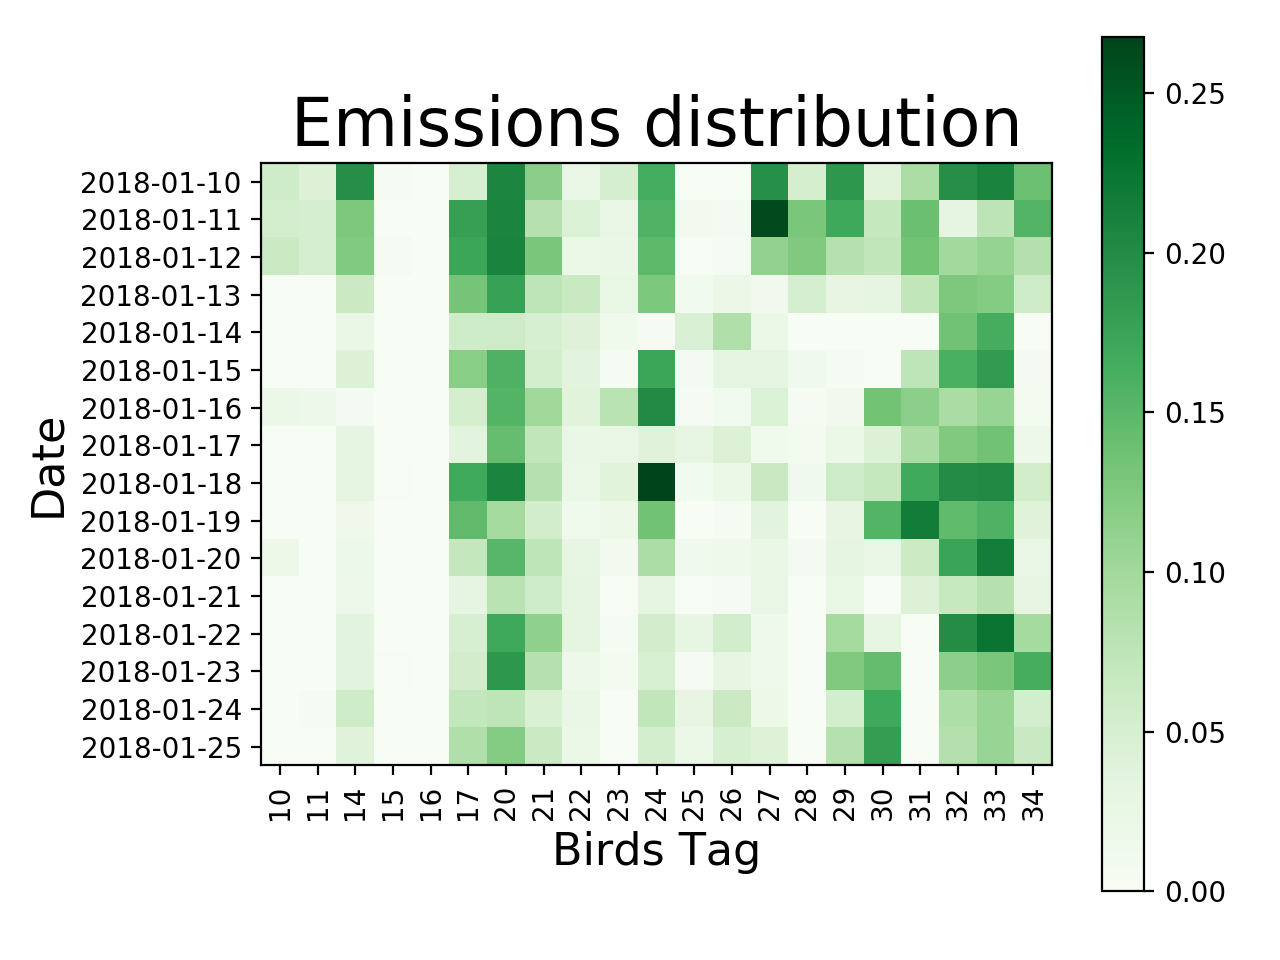

In [29]:
dataset_piv = get_pivot_table(birds_data, "date", "tag_id")

plot_args = {
    'cmap': 'Greens',
    'title': {'label': 'Emissions distribution', 'fontsize': 24},
    'xlabel': {'xlabel': 'Birds Tag', 'fontsize': 16},
    'ylabel': {'ylabel': 'Date', 'fontsize': 16}
}

#normalized = dataset_piv/cantidad_maxima_emisiones_por_hora
normalized = dataset_piv/cantidad_maxima_emisiones_por_dia
plot_colormap(
    normalized,
    **plot_args
)

<IPython.core.display.Javascript object>


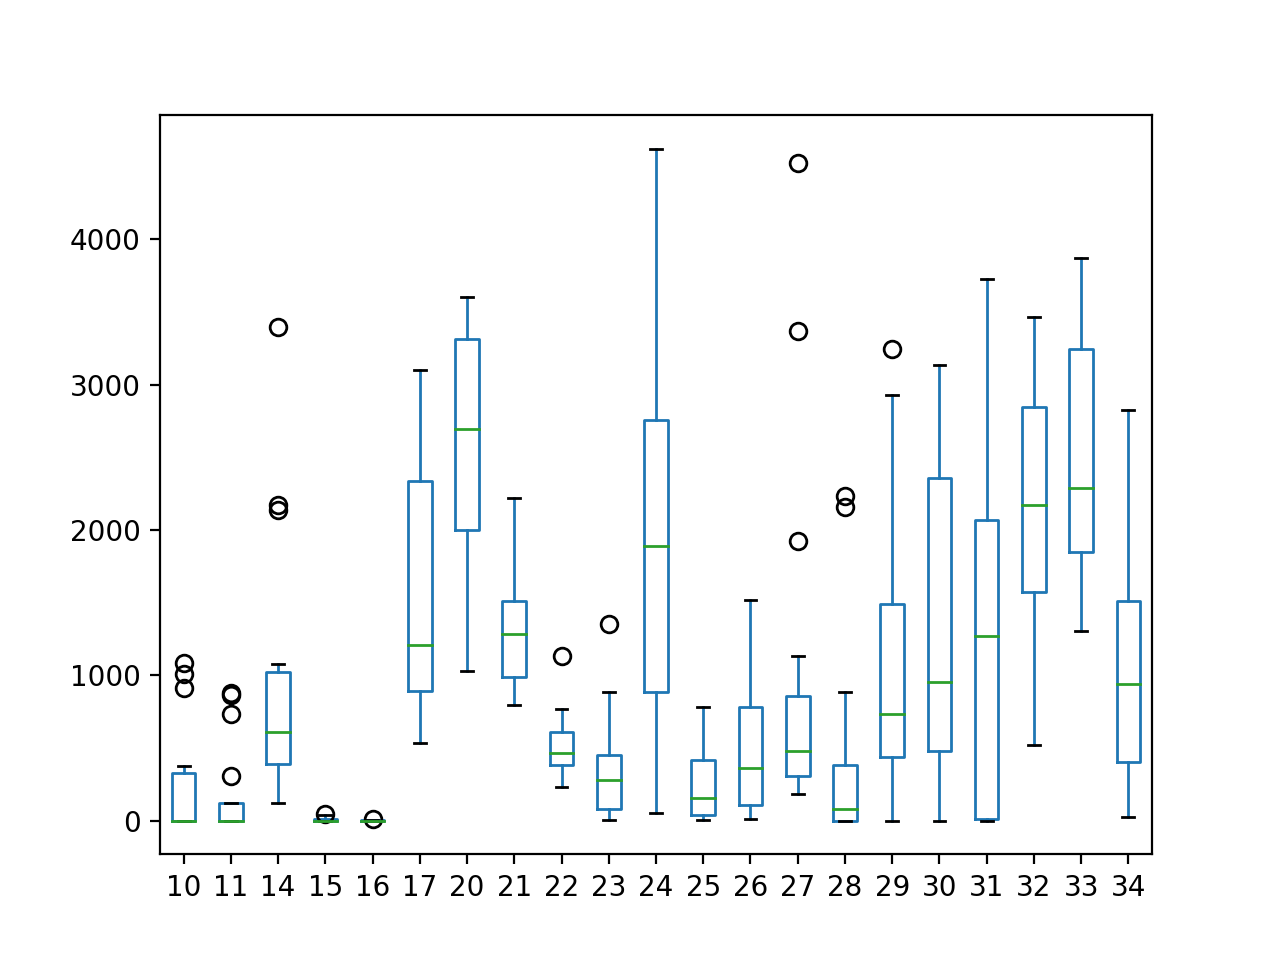

In [23]:
dataset_piv.plot.box()

### Señales continuas

In [49]:
birds_continuos_emissions = {}
for bird in MALES+FEMALES:
    birds_continuos_emissions[bird] = []

In [50]:
last_emission_by_bird = {}

In [70]:
MAX_ACCEPTABLE_DIFF_SEC = 60
#for index, emission in birds_data.iterrows():
sample = birds_data[
    (birds_data['tag_id'] == 32) #&
    #(birds_data['timestamp'] > '2018-01-18') &
    #(birds_data['timestamp'] < '2018-01-19')
].copy()
sample = birds_data.copy()
for index, emission in sample.iterrows():
    bird = emission['tag_id']
    timestamp = datetime.strptime(emission['timestamp'], '%Y-%m-%d %H:%M:%S')
    if bird in last_emission_by_bird:
        last_emission_time = last_emission_by_bird[bird]['end']
        if (timestamp-last_emission_time).total_seconds() < MAX_ACCEPTABLE_DIFF_SEC:
            last_emission_by_bird[bird]['end'] = timestamp
        else:
            continuos_total_time = (last_emission_by_bird[bird]['end']-last_emission_by_bird[bird]['start']).total_seconds()
            birds_continuos_emissions[bird].append(continuos_total_time)
            last_emission_by_bird[bird]['start'] = timestamp
            last_emission_by_bird[bird]['end'] = timestamp
    else:
        last_emission_by_bird[bird] = {'start':timestamp, 'end': timestamp}

for bird, last_emission in last_emission_by_bird.items():
    continuos_total_time = (last_emission['end']-last_emission['start']).total_seconds()
    birds_continuos_emissions[bird].append(continuos_total_time)

In [97]:
birds_continuos_emissions_df = (
    pd.DataFrame(pd.concat({k: pd.Series(v) for k, v in birds_continuos_emissions.items()}))
    .reset_index()
    .drop(columns=['level_1'])
    .rename(columns={'level_0': 'bird'})
    .set_index('bird')
)


In [71]:
bins = np.arange(0,1500, 50)

<IPython.core.display.Javascript object>


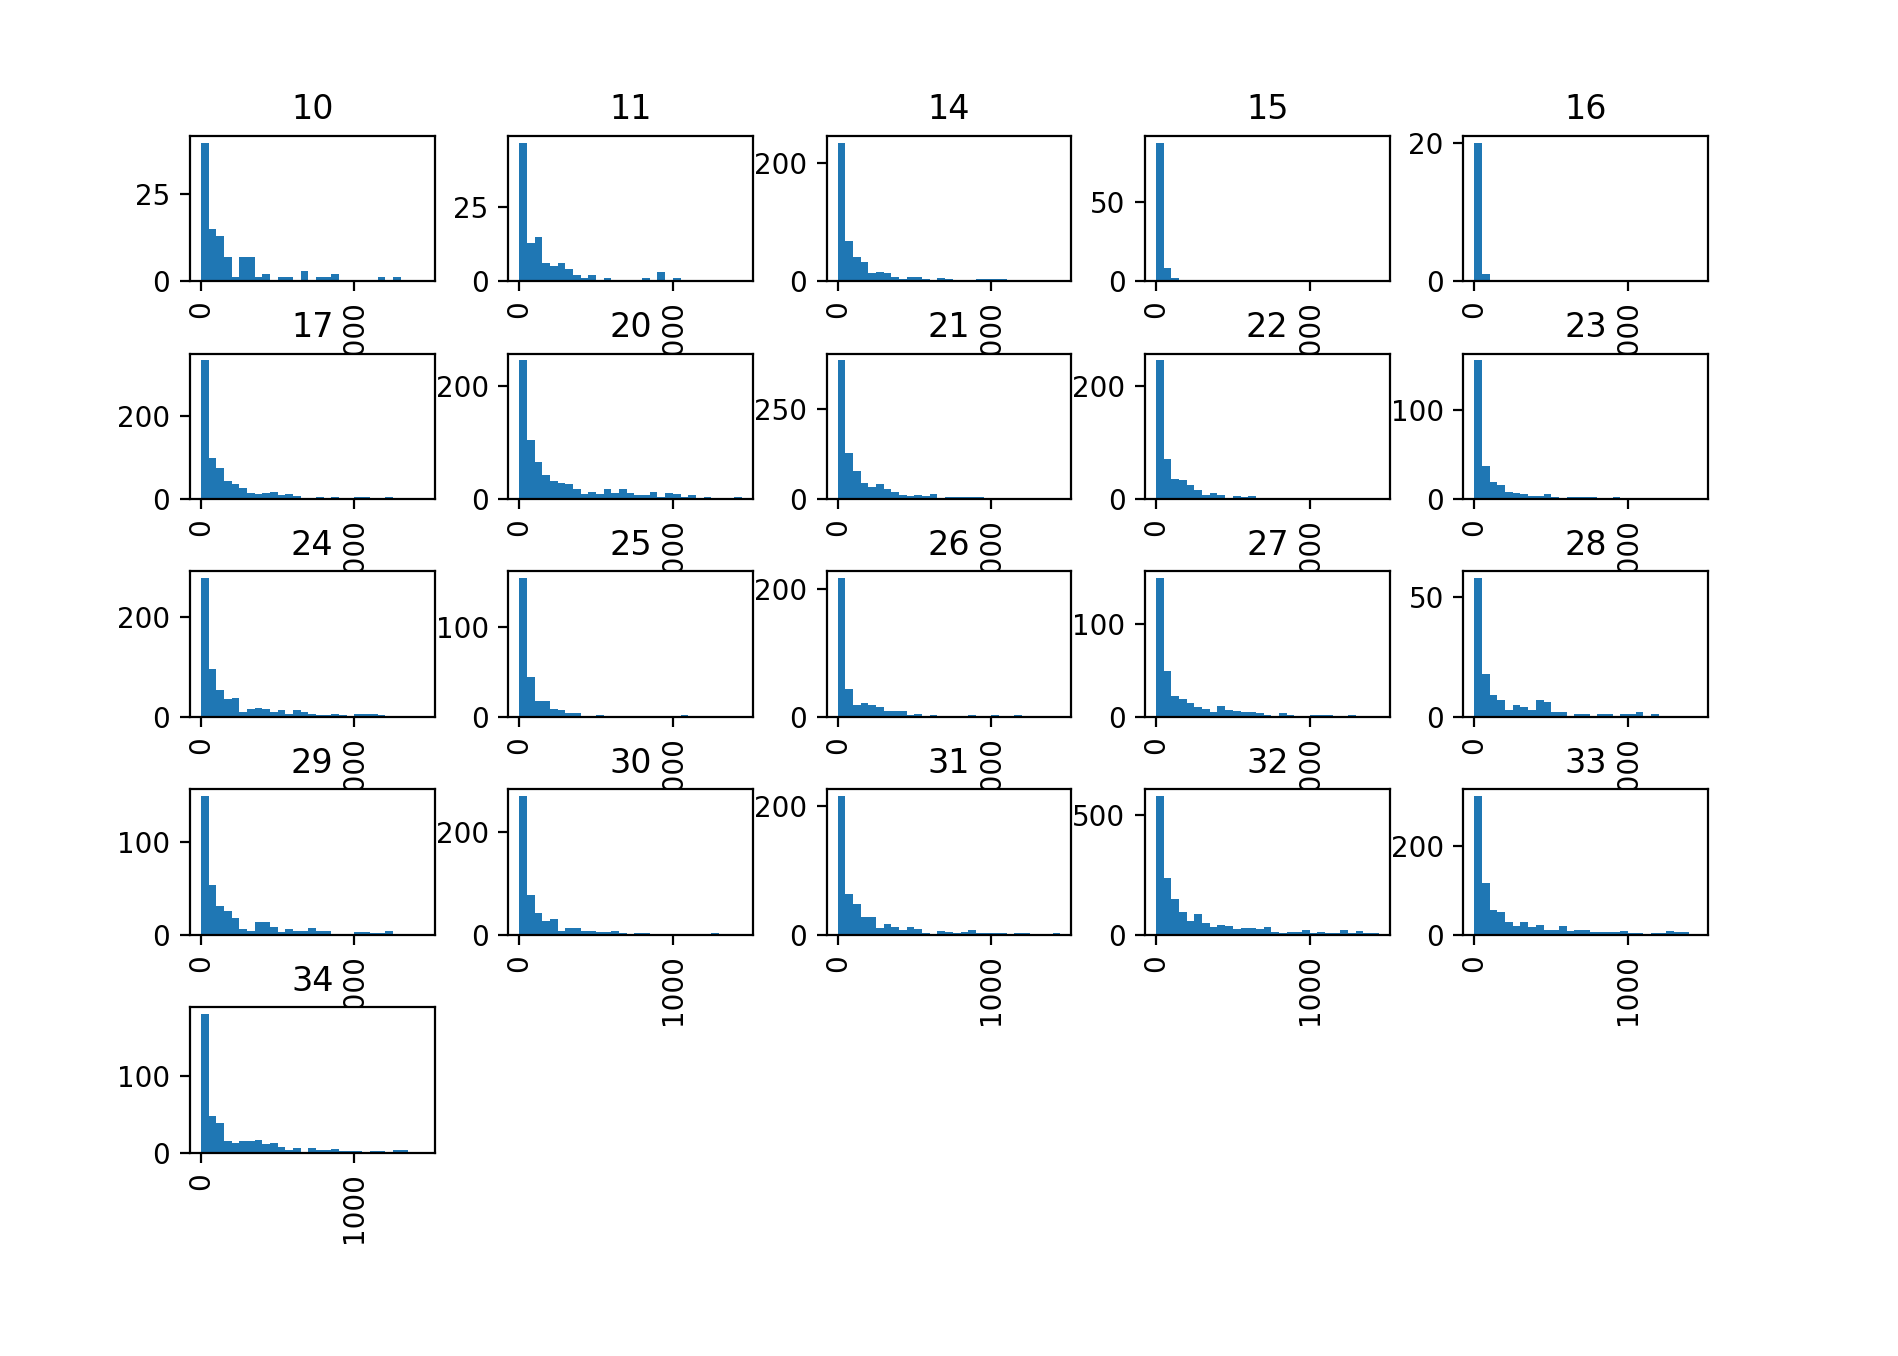

In [113]:
axs = birds_continuos_emissions_df.reset_index().hist(bins=bins, by='bird', column=0)


In [82]:
sample = birds_data[
    (birds_data['timestamp'] > '2018-01-18') &
    (birds_data['timestamp'] < '2018-01-19')
].copy()

sample['minute'] = sample['minute'] = sample['timestamp'].str.split(':').str[1].astype(int)+sample['timestamp'].str.split(' ').str[1].str.split(':').str[0].astype(int)*60


In [114]:
by_minute = pd.DataFrame(sample[sample['tag_id']==32].groupby('minute').size(), columns=['qty'])

In [115]:
missing_values = pd.DataFrame(np.arange(by_minute.index.min(), by_minute.index.max()), columns=['minute']).set_index('minute')
missing_values['qty'] = 0

In [116]:
by_minute_full = pd.concat([by_minute.reset_index(), missing_values.reset_index()]).groupby(['minute']).sum()

<IPython.core.display.Javascript object>


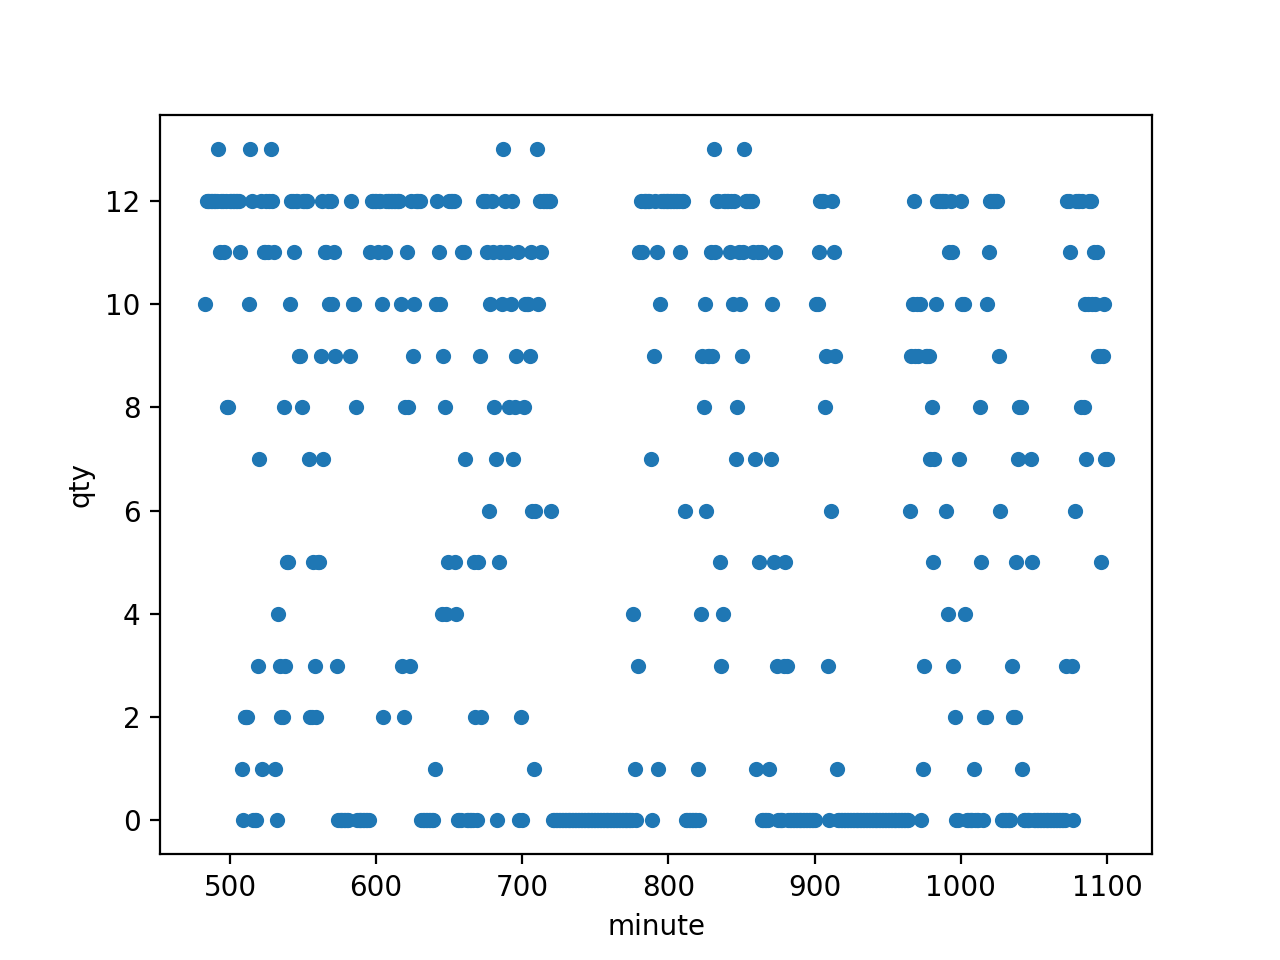

In [118]:
by_minute_full.reset_index().plot(kind='scatter', x='minute', y='qty')